# Auswertung der ersten Messungen

In [502]:
import json
import glob
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

d = {
}

expected_results_input = "./../expectedResults.json"

folder = "./../testresults/*.json"

file_list = glob.glob(folder)

data_array = []

with open (expected_results_input) as f:
    expected_results = json.load(f)
    print(expected_results)

{'name': 'Erwartetete Testergebnisse der Testsuite', 'desprcition': '10 QPS, 120 Sekunden, 1200 Request, Transienete Störungen für  40s', 'testcases': [{'name': 'normal', 'description': 'Noramles Verhalten - Positivtestfall', 'response-count': {'min': 1200, 'max': 1200}, 'RetCodes': {'200': {'min': 1200, 'max': 1200}, '500': {'min': 0, 'max': 0}, '503': {'min': 0, 'max': 0}, 'Other': {'min': 0, 'max': 0}}, 'Percentiles': {'50': {'min': 0, 'max': 0.1}, '90': {'min': 0, 'max': 0.2}}}, {'name': 'perm-error', 'description': 'Permanente Fehler', 'response-count': {'min': 1200, 'max': 1200}, 'RetCodes': {'200': {'min': 0, 'max': 0}, '500': {'min': 0, 'max': 100, '__comment': '10 Sekunden (100 Anfragen) Erkennungszeit wird geduldet'}, '503': {'min': 1000, 'max': 1200}, 'Other': {'min': 0, 'max': 0}}, 'Percentiles': {'50': {'min': 0, 'max': 0.1}, '90': {'min': 0, 'max': 0.2}}}]}


In [503]:
    
for file in file_list:
    with open(file) as f:
      json_data = json.load(f)
    row_dataframe = pd.json_normalize(json_data)
    percentiles_dataframe = pd.json_normalize(json_data['DurationHistogram']['Percentiles'])
    
    if "ErrorsDurationHistogram" in json_data:
        if json_data["ErrorsDurationHistogram"]["Count"] != 0:
            errors_percentiles_dataframe = pd.json_normalize(json_data['ErrorsDurationHistogram']['Percentiles'])
            row_dataframe['Errors50Percentile'] = errors_percentiles_dataframe[errors_percentiles_dataframe["Percentile"] == 50.0]['Value'] 
            row_dataframe['Errors90Percentile'] = errors_percentiles_dataframe.loc[3]['Value']

    row_dataframe['90Percentile'] = percentiles_dataframe.loc[3]['Value']
    row_dataframe['50Percentile'] = percentiles_dataframe[percentiles_dataframe["Percentile"] == 50.0]['Value']
   
    data_array.append(row_dataframe)

data = pd.concat(data_array, ignore_index=True)


#row_dataframe["TotalResponses"] = row_dataframe.filter(regex="RetCodes.*").sum(axis=1)
#Ausgabe der RetCodes der Istio-Testreihe
#data[data['Labels'].str.contains("-i-")].filter(regex="Label|RetCodes.*|50Percentile")

#Ausgabe der RetCodes der Traefik-Testreihe
overload_df = data[data['Labels'].str.contains("trans-overload-t-")]
overload_df = overload_df.fillna(0.0)
overload_df['Labels'] = overload_df['Labels'].replace({'trans-overload-t-':'','with-config-traefik-cb':'traefik','with-r4j-cb':'r4j','without-cb':'none','with-default-traefik':'df-traefik'},regex=True)
overload_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile|90Percentile")
#percentiles_dataframe.loc[3]['Value']

,Labels,DurationHistogram.Count,ErrorsDurationHistogram.Count,RetCodes.200,RetCodes.503,Errors50Percentile,Errors90Percentile,90Percentile,50Percentile,RetCodes.-1,RetCodes.500
0,traefik-4-all,1200,390,810.0,390.0,0.006725,0.020749,0.241964,0.026134,0.0,0.0
12,traefik-4-90-res,1200,390,810.0,390.0,0.006095,0.015050,0.240984,0.025363,0.0,0.0
40,df-traefik,1200,0,1200.0,0.0,0.000000,0.000000,0.425000,0.041929,0.0,0.0
46,traefik-1-consErrors,1200,0,1200.0,0.0,0.000000,0.000000,0.297059,0.040625,0.0,0.0
68,traefik-3-avg-res,1200,271,929.0,271.0,0.006938,0.025725,0.266742,0.030647,0.0,0.0
71,traefik-2-err-duration,1200,0,1200.0,0.0,0.000000,0.000000,0.280000,0.033778,0.0,0.0
111,none,1200,0,1200.0,0.0,0.000000,0.000000,0.294828,0.039419,0.0,0.0


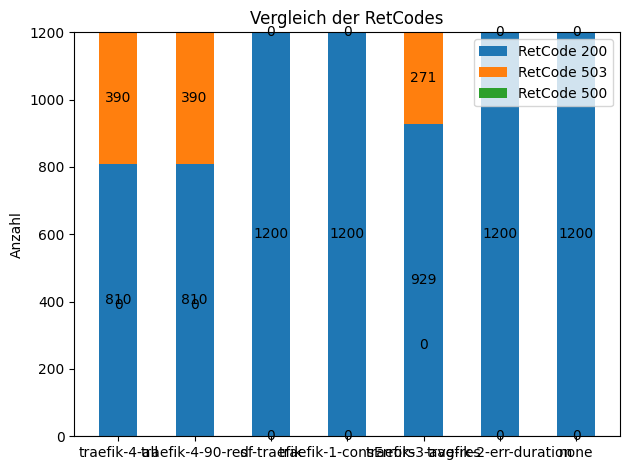

In [504]:
N = overload_df.shape[0]

ind = np.arange(N)*10   # the x locations for the groups
width = 5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()


p1 = ax.bar(ind, list(overload_df['RetCodes.200']), width, label='RetCode 200')
p2 = ax.bar(ind, list(overload_df['RetCodes.503']), width, list(overload_df['RetCodes.200']), label='RetCode 503')
p3 = ax.bar(ind, list(overload_df['RetCodes.500']), width, list(overload_df['RetCodes.503']), label='RetCode 500')

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Anzahl')
ax.set_title('Vergleich der RetCodes')
ax.set_xticks(ind, labels=list(overload_df['Labels']))
ax.legend()

# Label with label_type 'center' instead of the default 'edge'
ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p3, label_type='center')

plt.show()

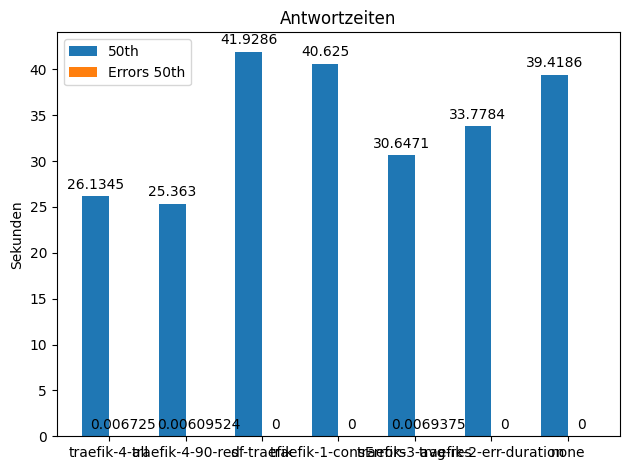

In [505]:

#see: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
labels = overload_df['Labels']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, list(overload_df['50Percentile']*1000), width, label='50th')
rects2 = ax.bar(x + width/2, list(overload_df['Errors50Percentile']), width, label='Errors 50th')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sekunden')
ax.set_title('Antwortzeiten')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [506]:
#Ausgabe der RetCodes der Traefik-Testreihe
relevant_testdate_df = data #data[data['StartTime'].str.contains("2022-06-30")]

relevant_testdate_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile|StartTime").sort_values(by=['StartTime'])
relevant_testdate_df.to_csv("rohdaten.csv")

## Auswertung - Normales Verhalten

In [507]:
normal_df = relevant_testdate_df[relevant_testdate_df['Labels'].str.contains("normal")]
normal_df = normal_df.fillna(0.0)
#normal_df['Labels'] = normal_df['Labels'].replace({'normal':'','with-config-traefik-cb':'traefik','with-r4j-cb':'r4j','without-cb':'none','with-default-traefik':'df-traefik'},regex=True)
normal_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile")

,Labels,DurationHistogram.Count,ErrorsDurationHistogram.Count,RetCodes.200,RetCodes.503,Errors50Percentile,50Percentile,RetCodes.-1,RetCodes.500
16,normal-t-with-default-traefik,1200,0,1200.0,0.0,0.000000,0.029184,0.0,0.0
20,normal-r4j-nfa-all,1200,0,1200.0,0.0,0.000000,0.041971,0.0,0.0
22,normal-t-traefik-3-avg-res,1200,0,1200.0,0.0,0.000000,0.028292,0.0,0.0
23,normal-r4j-nfa-4,1200,0,1200.0,0.0,0.000000,0.041651,0.0,0.0
24,normal-t-traefik-4-90-res,1200,0,1200.0,0.0,0.000000,0.028306,0.0,0.0
26,normal-without-cb,1200,0,1200.0,0.0,0.000000,0.058316,0.0,0.0
28,normal-istio3-maxPenReq,1200,0,1200.0,0.0,0.000000,0.031928,0.0,0.0
43,normal-r4j-nfa-2,1200,0,1200.0,0.0,0.000000,0.049727,0.0,0.0
51,normal-istio2-maxReq,688,342,346.0,342.0,0.007273,0.018759,0.0,0.0
53,normal-t-traefik-2-err-duration,1200,0,1200.0,0.0,0.000000,0.028465,0.0,0.0


## Auswertung - Permanente Fehler

Testskript: Fehler im Testskript bei R4J, ist korrigiert, Testläufe müssen nachgeholt werden

In [508]:
perm_error_df = relevant_testdate_df[relevant_testdate_df['Labels'].str.contains("perm-error")]
perm_error_df = perm_error_df.fillna(0.0)
perm_error_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile|90Percentile")

,Labels,DurationHistogram.Count,ErrorsDurationHistogram.Count,RetCodes.200,RetCodes.503,Errors50Percentile,Errors90Percentile,90Percentile,50Percentile,RetCodes.-1,RetCodes.500
7,perm-error-t-traefik-1-consErrors,1200,1200,0.0,0.0,0.015937,0.120000,0.120000,0.015937,0.0,1200.0
11,perm-error-r4j-nfa-all,1200,1200,0.0,1178.0,0.077602,0.176000,0.176000,0.077602,0.0,22.0
18,perm-error-t-traefik-3-avg-res,1200,1200,0.0,0.0,0.013747,0.098571,0.098571,0.013747,0.0,1200.0
27,perm-error-istio3-maxPenReq,1200,1200,0.0,0.0,0.014548,0.030000,0.030000,0.014548,0.0,1200.0
30,perm-error-r4j-nfa-4,1200,1200,0.0,1178.0,0.080843,0.200000,0.200000,0.080843,0.0,22.0
42,perm-error-istio5-both,1200,1200,0.0,1189.0,0.006423,0.017500,0.017500,0.006423,0.0,11.0
48,perm-error-without-cb,1200,1200,0.0,0.0,0.016435,0.077500,0.077500,0.016435,0.0,1200.0
52,perm-error-t-without-cb,1200,1200,0.0,0.0,0.009394,0.065000,0.065000,0.009394,0.0,1200.0
64,perm-error-r4j-default,1200,1200,0.0,1094.0,0.092645,0.583333,0.583333,0.092645,0.0,106.0
76,perm-error-r4j-nfa-3,1200,1200,0.0,1174.0,0.076812,0.325000,0.325000,0.076812,0.0,26.0


## Auswertung - Permanete Überlast

Testskript: läuft, wie erwartet
Testläufe: Testlaufe ohne CB hat nicht stattgefunden

In [509]:
perm_overload_df = relevant_testdate_df[relevant_testdate_df['Labels'].str.contains("perm-overload")]
perm_overload_df =perm_overload_df.fillna(0.0)
perm_overload_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile")

,Labels,DurationHistogram.Count,ErrorsDurationHistogram.Count,RetCodes.200,RetCodes.503,Errors50Percentile,50Percentile,RetCodes.-1,RetCodes.500
1,perm-overload-r4j-nfa-3,1200,1183,17.0,1182.0,0.073624,0.074101,1.0,0.0
3,perm-overload-without-cb,411,6,405.0,0.0,5.282018,0.988816,6.0,0.0
4,perm-overload-r4j-nfa-1,1200,1198,2.0,1196.0,0.077572,0.077630,2.0,0.0
8,perm-overload-istio2-maxReq,1173,786,387.0,785.0,0.005500,0.012478,1.0,0.0
9,perm-overload-t-traefik-4-all,1200,1183,17.0,1183.0,0.005732,0.005809,0.0,0.0
32,perm-overload-t-without-cb,512,0,512.0,0.0,0.000000,0.905607,0.0,0.0
34,perm-overload-r4j-nfa-4,1200,1173,27.0,1173.0,0.079431,0.080278,0.0,0.0
41,perm-overload-t-traefik-2-err-duration,589,40,549.0,40.0,0.003889,0.841797,0.0,0.0
63,perm-overload-r4j-default,1200,1198,2.0,1186.0,0.092185,0.092269,12.0,0.0
86,perm-overload-t-traefik-3-avg-res,1200,1011,189.0,1011.0,0.006098,0.007195,0.0,0.0


## Auswertung - Transiente Fehler
Testskript: läuft
Testläufe: Abgebrochene / Falsche Testfälle dabei (Date-Problem)

In [510]:
trans_error_df = relevant_testdate_df[relevant_testdate_df['Labels'].str.contains("trans-error")]
trans_error_df = trans_error_df.fillna(0.0)
trans_error_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile")

,Labels,DurationHistogram.Count,ErrorsDurationHistogram.Count,RetCodes.200,RetCodes.503,Errors50Percentile,50Percentile,RetCodes.-1,RetCodes.500
10,trans-error-istio4-maxCon,1200,400,800.0,0.0,0.017180,0.030720,0.0,400.0
25,trans-error-r4j-nfa-all,1200,648,552.0,595.0,0.068333,0.045156,0.0,53.0
35,trans-error-t-traefik-2-err-duration,1200,436,764.0,378.0,0.007583,0.024714,0.0,58.0
39,trans-error-r4j-default,1200,648,552.0,598.0,0.074615,0.057094,0.0,50.0
44,trans-error-t-without-cb,1200,400,800.0,0.0,0.009585,0.025128,0.0,400.0
49,trans-error-r4j-nfa-2,1200,648,552.0,597.0,0.071622,0.052650,0.0,51.0
50,trans-error-r4j-nfa-4,1200,648,552.0,598.0,0.075882,0.053333,0.0,50.0
58,trans-error-istio2-maxReq,1200,799,401.0,594.0,0.009233,0.016178,0.0,205.0
59,trans-error-t-traefik-4-all,1200,603,597.0,541.0,0.006623,0.018143,0.0,62.0
60,trans-error-t-with-default-traefik,1200,400,800.0,0.0,0.013349,0.026240,0.0,400.0


## Auswertung - Transiente Überlast

In [511]:
trans_overload_df = relevant_testdate_df[relevant_testdate_df['Labels'].str.contains("trans-overload")]
trans_overload_df = trans_overload_df.fillna(0.0)
trans_overload_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile")

,Labels,DurationHistogram.Count,ErrorsDurationHistogram.Count,RetCodes.200,RetCodes.503,Errors50Percentile,50Percentile,RetCodes.-1,RetCodes.500
0,trans-overload-t-traefik-4-all,1200,390,810.0,390.0,0.006725,0.026134,0.0,0.0
2,trans-overload-istio4-maxCon,1200,0,1200.0,0.0,0.000000,0.040347,0.0,0.0
12,trans-overload-t-traefik-4-90-res,1200,390,810.0,390.0,0.006095,0.025363,0.0,0.0
13,trans-overload-r4j-nfa-all,1200,0,1200.0,0.0,0.000000,0.042315,0.0,0.0
29,trans-overload-istio3-maxPenReq,1200,0,1200.0,0.0,0.000000,0.037621,0.0,0.0
37,trans-overload-istio1-consErrors,1200,0,1200.0,0.0,0.000000,0.038885,0.0,0.0
40,trans-overload-t-with-default-traefik,1200,0,1200.0,0.0,0.000000,0.041929,0.0,0.0
46,trans-overload-t-traefik-1-consErrors,1200,0,1200.0,0.0,0.000000,0.040625,0.0,0.0
47,trans-overload-r4j-default,1200,0,1200.0,0.0,0.000000,0.042385,0.0,0.0
54,trans-overload-istio2-maxReq,1200,598,602.0,598.0,0.006460,0.019360,0.0,0.0


## Auswertung - Sporadische Fehler

In [512]:
spor_error_df = relevant_testdate_df[relevant_testdate_df['Labels'].str.contains("spor-error")]
spor_error_df = spor_error_df.fillna(0.0)
spor_error_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile")

,Labels,DurationHistogram.Count,ErrorsDurationHistogram.Count,RetCodes.200,RetCodes.503,Errors50Percentile,50Percentile,RetCodes.-1,RetCodes.500
5,spor-error-r4j-nfa-2,1200,1180,20.0,1155.0,0.072111,0.071608,0.0,25.0
6,spor-error-istio5-both,1200,1193,7.0,1182.0,0.006504,0.006532,0.0,11.0
17,spor-error-r4j-nfa-all,1200,1186,14.0,1174.0,0.069583,0.069358,0.0,12.0
19,spor-error-t-traefik-3-avg-res,1200,708,492.0,0.0,0.011754,0.017407,0.0,708.0
21,spor-error-t-traefik-2-err-duration,1200,1142,58.0,1053.0,0.005079,0.005310,0.0,89.0
31,spor-error-istio4-maxCon,1200,746,454.0,0.0,0.013726,0.018140,0.0,746.0
45,spor-error-t-traefik-1-consErrors,1200,721,479.0,0.0,0.011794,0.017759,0.0,721.0
55,spor-error-t-traefik-4-90-res,1200,715,485.0,0.0,0.010360,0.016615,0.0,715.0
57,spor-error-t-without-cb,1200,710,490.0,0.0,0.007934,0.013231,0.0,710.0
61,spor-error-istio1-consErrors,1200,1183,17.0,1152.0,0.005795,0.005856,0.0,31.0


## Auswertung - Sporadische Überlast

In [513]:
spor_overload_df = relevant_testdate_df[relevant_testdate_df['Labels'].str.contains("spor-overload")]
spor_overload_df = spor_overload_df.fillna(0.0)
spor_overload_df.filter(regex="Label|RetCodes.*|DurationHistogram.Count|50Percentile")

,Labels,DurationHistogram.Count,ErrorsDurationHistogram.Count,RetCodes.200,RetCodes.503,Errors50Percentile,50Percentile,RetCodes.-1,RetCodes.500
14,spor-overload-without-cb,1200,0,1200.0,0.0,0.000000,0.208636,0.0,0.0
15,spor-overload-istio1-consErrors,1200,0,1200.0,0.0,0.000000,0.208445,0.0,0.0
33,spor-overload-t-traefik-4-90-res,1200,1106,94.0,1106.0,0.005780,0.006227,0.0,0.0
36,spor-overload-t-traefik-3-avg-res,1200,775,425.0,775.0,0.006517,0.008902,0.0,0.0
38,spor-overload-t-traefik-1-consErrors,1200,0,1200.0,0.0,0.000000,0.208297,0.0,0.0
56,spor-overload-r4j-nfa-1,1200,0,1200.0,0.0,0.000000,0.211148,0.0,0.0
62,spor-overload-r4j-nfa-2,1200,0,1200.0,0.0,0.000000,0.210148,0.0,0.0
72,spor-overload-r4j-nfa-4,1200,0,1200.0,0.0,0.000000,0.208239,0.0,0.0
73,spor-overload-r4j-nfa-all,1200,0,1200.0,0.0,0.000000,0.208997,0.0,0.0
74,spor-overload-t-without-cb,1200,0,1200.0,0.0,0.000000,0.209655,0.0,0.0


## Auswertung Diagramm

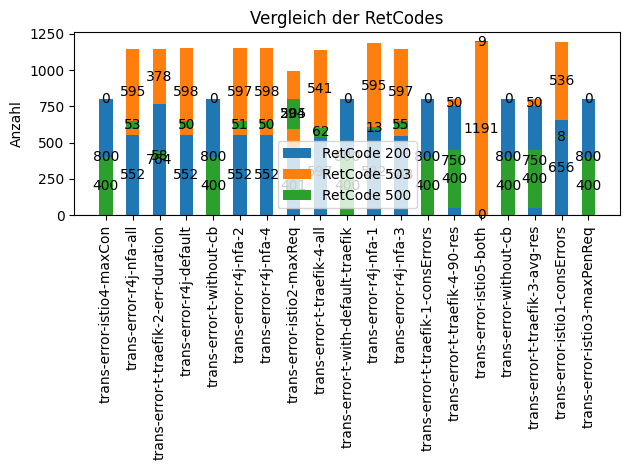

In [514]:
### Insert dataframe for diagramm here
diagramm_df = trans_error_df
diagramm_df['Labels'] = diagramm_df['Labels'].replace({'overload-':'','-with-config-traefik-cb':'traefik','-with-r4j-cb-':'r4j','-without-cb-':'none','with-default-traefik-':'df-traefik'},regex=True)
###


N = diagramm_df.shape[0]

ind = np.arange(N)   # the x locations for the groups
width = 0.5      # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()


p1 = ax.bar(ind, list(diagramm_df['RetCodes.200']), width, label='RetCode 200')
p2 = ax.bar(ind, list(diagramm_df['RetCodes.503']), width,list(diagramm_df['RetCodes.200']), label='RetCode 503')
p3 = ax.bar(ind, list(diagramm_df['RetCodes.500']), width, list(diagramm_df['RetCodes.503']), label='RetCode 500')

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Anzahl')
ax.set_title('Vergleich der RetCodes')
ax.set_xticks(ind, labels=list(diagramm_df['Labels']),rotation=90)
ax.legend()

# Label with label_type 'center' instead of the default 'edge'
ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p3, label_type='center')

fig.savefig("retcodes-export.pdf")
plt.show()

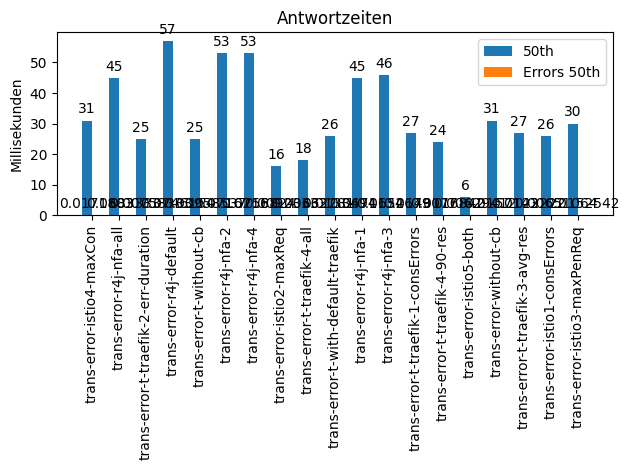

In [515]:

#see: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
labels = diagramm_df['Labels']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

diagramm_df['50Percentile'] = np.round(diagramm_df['50Percentile']*1000)

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, list(diagramm_df['50Percentile']), width, label='50th')
rects2 = ax.bar(x + width/2, list(diagramm_df['Errors50Percentile']), width, label='Errors 50th')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Millisekunden')
ax.set_title('Antwortzeiten')
ax.set_xticks(x, labels, rotation=90)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

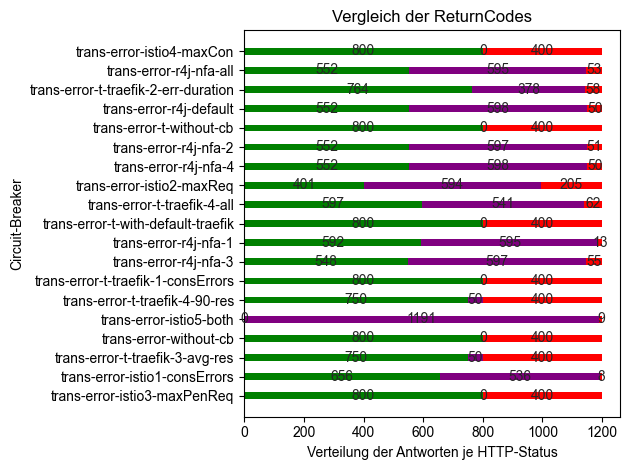

In [516]:
#plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
mpl.style.use('seaborn')
hdia_df = trans_error_df

y_pos = np.arange(len(hdia_df))

p1 = ax.barh(ind, list(hdia_df['RetCodes.200']), width, left=0, label='200',color="green")
p2 = ax.barh(ind, list(hdia_df['RetCodes.503']), width, left=list(hdia_df['RetCodes.200']), label='503', color="purple")
p3 = ax.barh(ind, list(hdia_df['RetCodes.500']), width, left=list(hdia_df['RetCodes.200']+hdia_df['RetCodes.503']), label='500', color="red")

ax.set_yticks(y_pos, labels=hdia_df['Labels'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Verteilung der Antworten je HTTP-Status')
ax.set_ylabel('Circuit-Breaker')
ax.set_title('Vergleich der ReturnCodes')

ax.bar_label(p1, label_type="center")
ax.bar_label(p2,label_type="center")
ax.bar_label(p3, label_type="center")

#ax.legend()

plt.show()

In [ ]:
def exportRetCodeDiagramm(diagramm_df, filename, title):
    mpl.style.use('seaborn')
    plt.rcdefaults()
    mpl.rcParams.update({'figure.autolayout': True})
    
    N = diagramm_df.shape[0]
    ind = np.arange(N)   
    width = 0.8 
    
    fig, ax = plt.subplots()
    
    p1 = ax.barh(ind, list(diagramm_df['RetCodes.200']), width, left=0, label='200',color="green")
    p2 = ax.barh(ind, list(diagramm_df['RetCodes.503']), width, left=list(diagramm_df['RetCodes.200']), label='503', color="purple")
    p3 = ax.barh(ind, list(diagramm_df['RetCodes.500']), width, left=list(diagramm_df['RetCodes.200']+diagramm_df['RetCodes.503']), label='500', color="red")
    ax.set_yticks(ind, labels=diagramm_df['Labels'])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Verteilung der Antworten je HTTP-Status')
    ax.set_ylabel('Circuit-Breaker')
    ax.set_title(title)
    
    ax.bar_label(p1, label_type="center")
    ax.bar_label(p2,label_type="center")
    ax.bar_label(p3, label_type="center")
    
    fig.savefig(filename)
    
def exportRespTimeDiagramm(diagramm_df, filename, title):
    labels = diagramm_df['Labels']
    ind = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    diagramm_df['50Percentile'] = np.round(diagramm_df['50Percentile']*1000)
    diagramm_df['90Percentile'] = np.round(diagramm_df['90Percentile']*1000)
    fig, ax = plt.subplots()
    rects1 = ax.barh(ind - width/2, list(diagramm_df['50Percentile']), width, label='50th')
    rects3 = ax.barh(ind + width/2, list(diagramm_df['90Percentile']), width, label='90th')

    ax.legend()
    ax.set_yticks(ind, labels=diagramm_df['Labels'])
    
    #ax.set_xscale('log')

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects3, padding=3)
    
    ax.set_xlabel('Antwortzeit in Millisekunden')
    ax.set_ylabel('Circuit-Breaker')
    ax.set_title(title)

    fig.savefig(filename)


normal_df['Labels'] = normal_df['Labels'].replace({'normal-':''},regex=True)
exportRetCodeDiagramm(normal_df, "evaluationresults/1a-normal-retcodes.pdf","Normales Verhalten: HTTP-Status-Codes")
exportRespTimeDiagramm(normal_df, "evaluationresults/1b-normal-resp-time.pdf","Normales Verhalten: Antwortzeiten")

perm_error_df['Labels'] = perm_error_df['Labels'].replace({'perm-error-':''},regex=True)
exportRetCodeDiagramm(perm_error_df, "evaluationresults/2a-perm-error-retcodes.pdf","Permanente Fehler: HTTP-Status-Codes")
exportRespTimeDiagramm(perm_error_df, "evaluationresults/2b-perm-error-resp-time.pdf","Permanente Fehler: Antwortzeiten")

perm_overload_df['Labels'] = perm_overload_df['Labels'].replace({'perm-overload-':''},regex=True)
exportRetCodeDiagramm(perm_overload_df, "evaluationresults/3a-perm-overload-retcodes.pdf","Permanente Überlast: HTTP-Status-Codes")
exportRespTimeDiagramm(perm_overload_df, "evaluationresults/3b-perm-overload-resp-time.pdf","Permanente Überlast: Antwortzeiten")

trans_error_df['Labels'] = trans_error_df['Labels'].replace({'trans-error-':''},regex=True)
exportRetCodeDiagramm(trans_error_df, "evaluationresults/4a-trans-error-retcodes.pdf","Transiente Fehler: HTTP-Status-Codes")
exportRespTimeDiagramm(trans_error_df, "evaluationresults/4b-trans-error-resp-time.pdf","Transiente Fehler: Antwortzeiten")

trans_overload_df['Labels'] = trans_overload_df['Labels'].replace({'trans-overload-':''},regex=True)
exportRetCodeDiagramm(trans_overload_df, "evaluationresults/5a-trans-overload-retcodes.pdf","Transiente Überlast: HTTP-Status-Codes")
exportRespTimeDiagramm(trans_overload_df, "evaluationresults/5b-trans-overload-resp-time.pdf","Transiente Überlast: Antwortzeiten")

spor_error_df['Labels'] = spor_error_df['Labels'].replace({'spor-error-':''},regex=True)
exportRetCodeDiagramm(spor_error_df, "evaluationresults/6a-spor-error-retcodes.pdf","Sporadische Fehler: HTTP-Status-Codes")
exportRespTimeDiagramm(spor_error_df, "evaluationresults/6b-spor-error-resp-time.pdf","Sporadische Fehler: Antwortzeiten")

spor_overload_df['Labels'] = spor_overload_df['Labels'].replace({'spor-overload-':''},regex=True)
exportRetCodeDiagramm(spor_overload_df, "evaluationresults/7a-spor-overload-retcodes.pdf","Sporadische Überlast: HTTP-Status-Codes")
exportRespTimeDiagramm(spor_overload_df, "evaluationresults/7b-spor-overload-resp-time.pdf","Sporadische Überlast: Antwortzeiten")

